In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [14]:
# ==================== MAIN CLASS (ALL IN ONE) ====================


class RegressionAnalysisTool:
    def __init__(self, main_ticker, comparison_tickers):
        self.main_ticker = main_ticker
        self.comparison_tickers = comparison_tickers
        
    def fetch_data(self, ticker, period, interval):
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if data.empty:
                return None

            if isinstance(data, pd.DataFrame):
                if 'Close' in data.columns:
                    return data['Close']
                elif len(data.columns) > 0:
                    return data.iloc[:, 0]
            return data
        except Exception as e:
            print(f"Error fetching {ticker}: {e}")
            return None
    
    def calculate_returns(self, prices):
        if prices is None or len(prices) == 0:
            return None
        return prices.pct_change().dropna()
    
    def run_regression(self, x_returns, y_returns):
        if x_returns is None or y_returns is None:
            return None, None, None, None
            
        combined = pd.concat([x_returns, y_returns], axis=1, keys=['x', 'y']).dropna()
        
        x = combined['x'].values
        y = combined['y'].values

        mask = np.isfinite(x) & np.isfinite(y)
        x = x[mask]
        y = y[mask]

        if len(x) < 10:
            return None, None, None, None
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        
        return slope, intercept, r_value**2, p_value
    
    def plot_regression(self, main_ticker_name, comp_ticker_name, timeframes_data):
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f'{comp_ticker_name} vs {main_ticker_name} - Multi-Timeframe Regression', 
                     fontsize=16, fontweight='bold')
        
        titles = ['1 Week (5m intervals)', '1 Month (30m intervals)', '1 Year (1d intervals)']
        
        for idx, (ax, title) in enumerate(zip(axes, titles)):
            data = timeframes_data[idx]
            
            if data is None:
                ax.text(0.5, 0.5, 'No data available', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(title)
                continue
            
            x_ret = data['x_returns']
            y_ret = data['y_returns']
            slope = data['beta']
            intercept = data['intercept']
            r2 = data['r2']
            p_value = data['p_value']
            
            combined = pd.concat([x_ret, y_ret], axis=1, keys=['x', 'y']).dropna()
            x = combined['x'].values
            y = combined['y'].values
            
            ax.scatter(x, y, alpha=0.5, s=20)
            
            x_line = np.linspace(x.min(), x.max(), 100)
            y_line = slope * x_line + intercept
            ax.plot(x_line, y_line, 'r-', linewidth=2, label=f'β={slope:.3f}')
            
            ax.set_xlabel(f'{main_ticker_name} Returns', fontsize=10)
            ax.set_ylabel(f'{comp_ticker_name} Returns', fontsize=10)
            ax.set_title(title, fontsize=12, fontweight='bold')
            
            stats_text = f'Beta: {slope:.3f}\nR²: {r2:.3f}\np-value: {p_value:.6f}'
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
                   verticalalignment='top', bbox=dict(boxstyle='round', 
                   facecolor='wheat', alpha=0.5), fontsize=9)
            
            ax.legend(loc='lower right')
        
        plt.tight_layout()
        return fig
    
    def analyze_ticker(self, comp_ticker):
        print(f"\n{'='*80}")
        print(f"Analyzing: {comp_ticker} vs {self.main_ticker}")
        print(f"{'='*80}")
        
        timeframes = [
            ('5d', '5m', '1 Week'),
            ('1mo', '30m', '1 Month'),
            ('1y', '1d', '1 Year')
        ]
        
        actual_fetch = [
            ('5d', '5m'),
            ('1mo', '30m'), 
            ('1y', '1d')
        ]
        
        timeframes_data = []
        
        for idx, ((period, interval), (_, _, name)) in enumerate(zip(actual_fetch, timeframes)):
            
            main_prices = self.fetch_data(self.main_ticker, period, interval)
            comp_prices = self.fetch_data(comp_ticker, period, interval)
            
            if main_prices is None or comp_prices is None:
                print(f" [!] Data fetch failed")
                timeframes_data.append(None)
                continue
            

            main_returns = self.calculate_returns(main_prices)
            comp_returns = self.calculate_returns(comp_prices)
            
            beta, intercept, r2, p_value = self.run_regression(main_returns, comp_returns)
            
            if beta is None:
                print(f" [!] Insufficient data for regression")
                timeframes_data.append(None)
                continue
            
            
            timeframes_data.append({
                'x_returns': main_returns,
                'y_returns': comp_returns,
                'beta': beta,
                'intercept': intercept,
                'r2': r2,
                'p_value': p_value
            })
        
        fig = self.plot_regression(self.main_ticker, comp_ticker, timeframes_data)
        plt.show()
        
    def run_analysis(self):
        print(f"\n Starting Regression Analysis")
        print(f"Main Ticker: {self.main_ticker}")
        print(f"Comparison Tickers: {', '.join(self.comparison_tickers)}")
        
        for ticker in self.comparison_tickers:
            self.analyze_ticker(ticker)
        
        print(f"\n Analysis Complete!")


 Starting Regression Analysis
Main Ticker: BTC-USD
Comparison Tickers: ORCL, PLTR, SNOW, CRM, WDAY, DDOG, NET, CRWD, PANW, SNPS, ADBE, INTU, NOW, XSW, IGV

Analyzing: ORCL vs BTC-USD


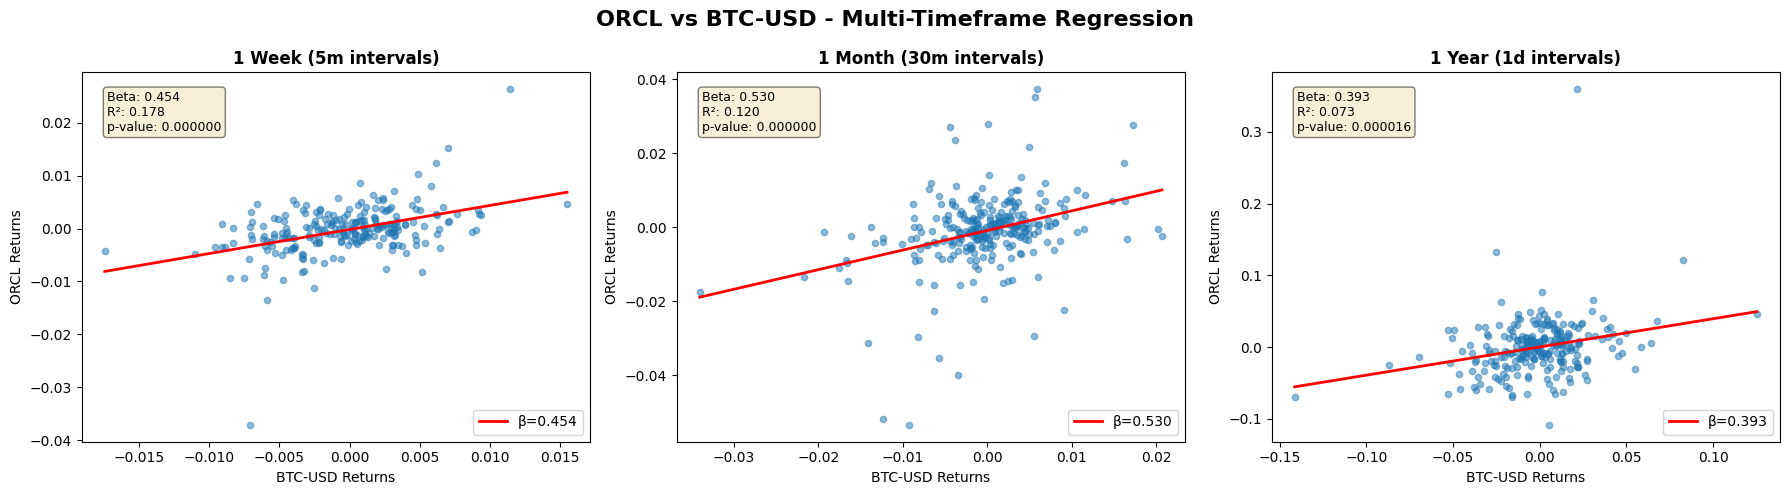


Analyzing: PLTR vs BTC-USD


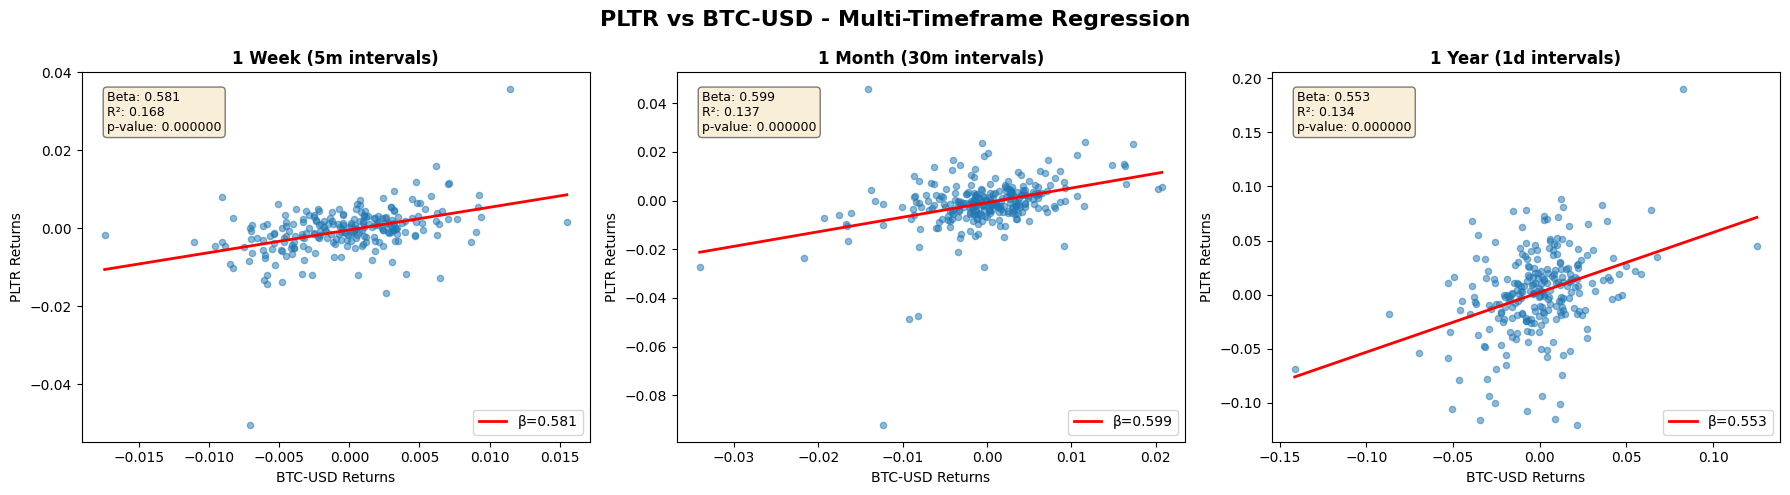


Analyzing: SNOW vs BTC-USD


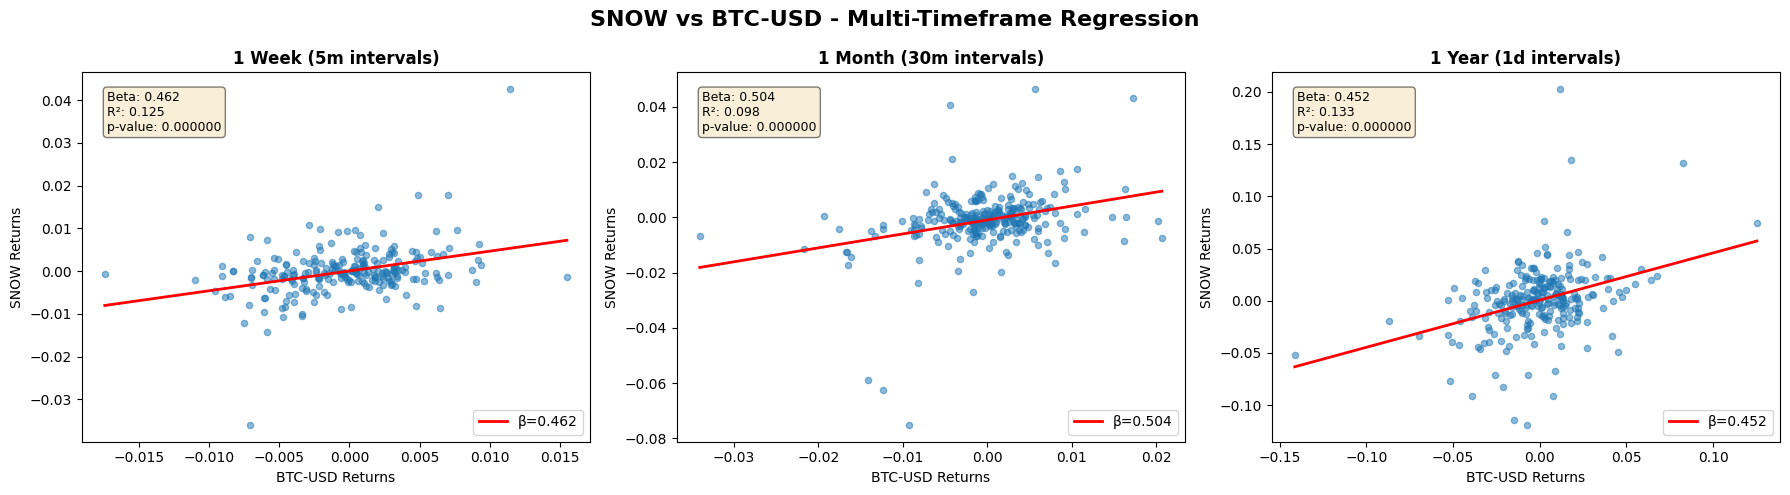


Analyzing: CRM vs BTC-USD


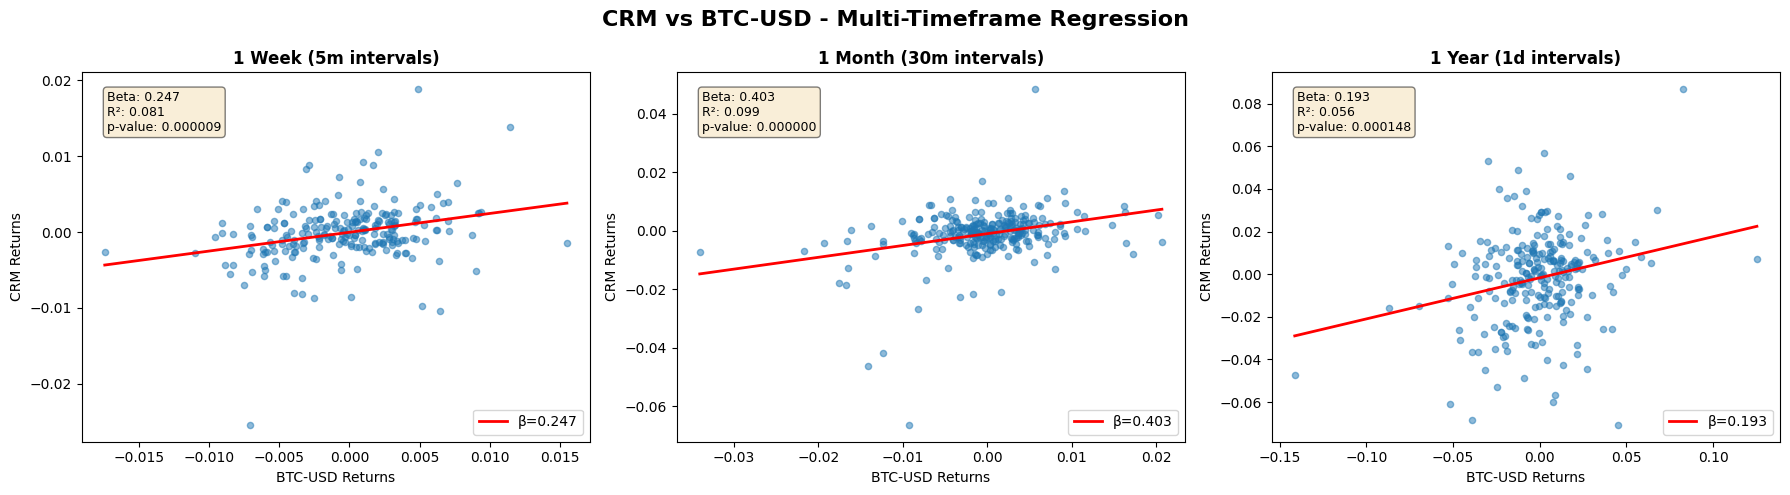


Analyzing: WDAY vs BTC-USD


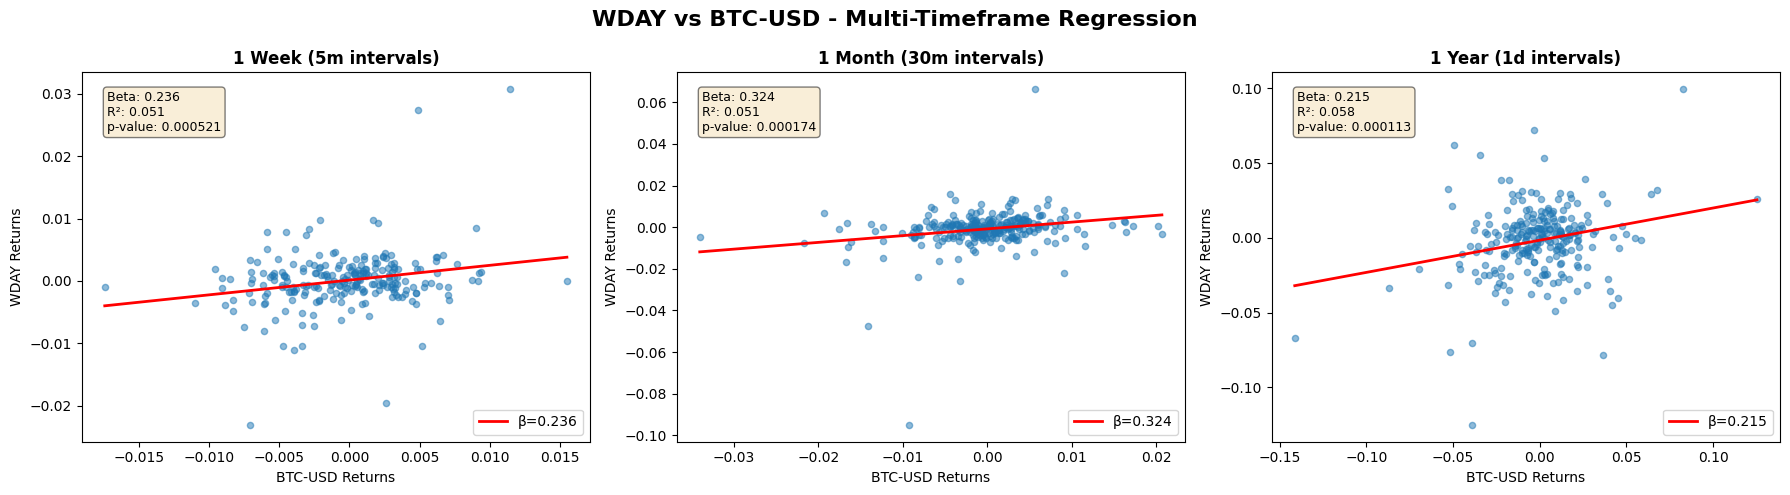


Analyzing: DDOG vs BTC-USD


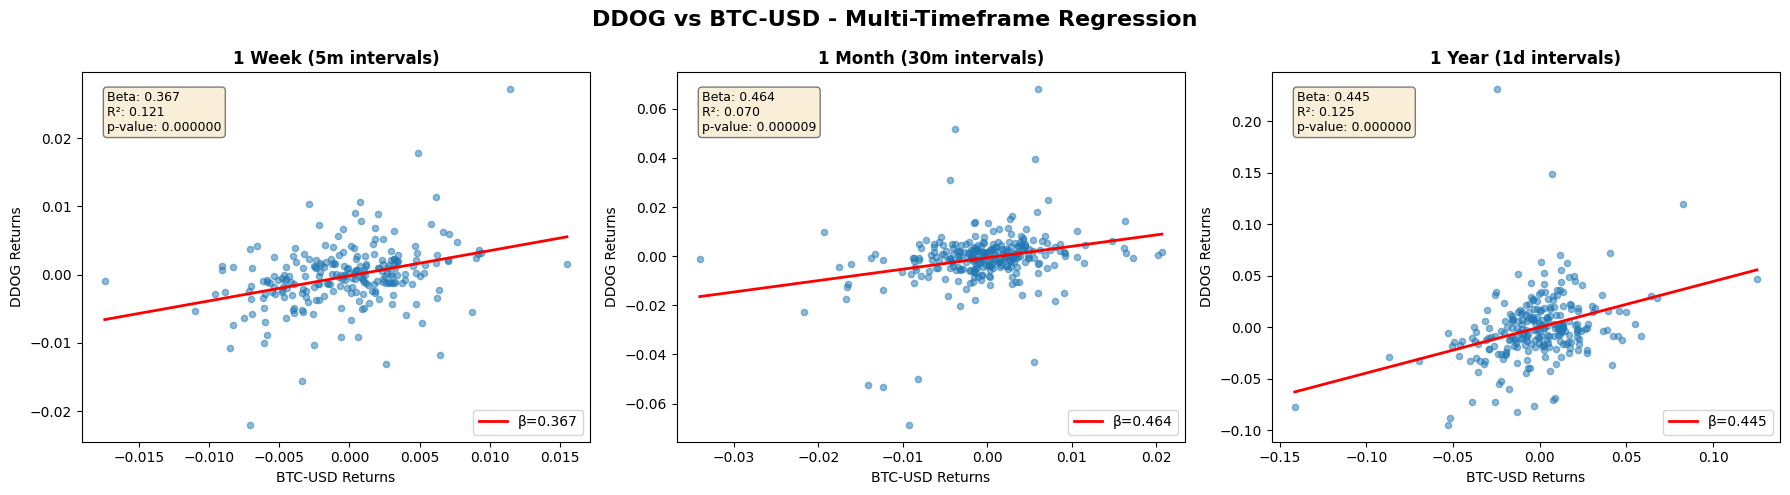


Analyzing: NET vs BTC-USD


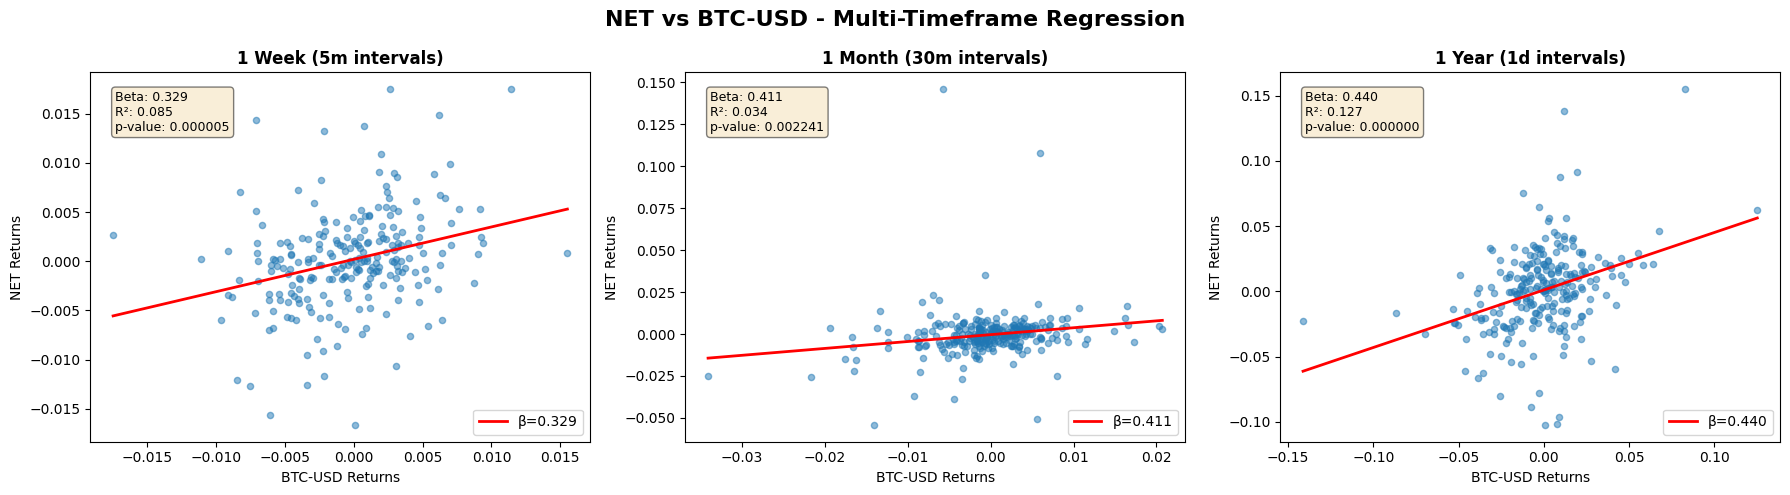


Analyzing: CRWD vs BTC-USD


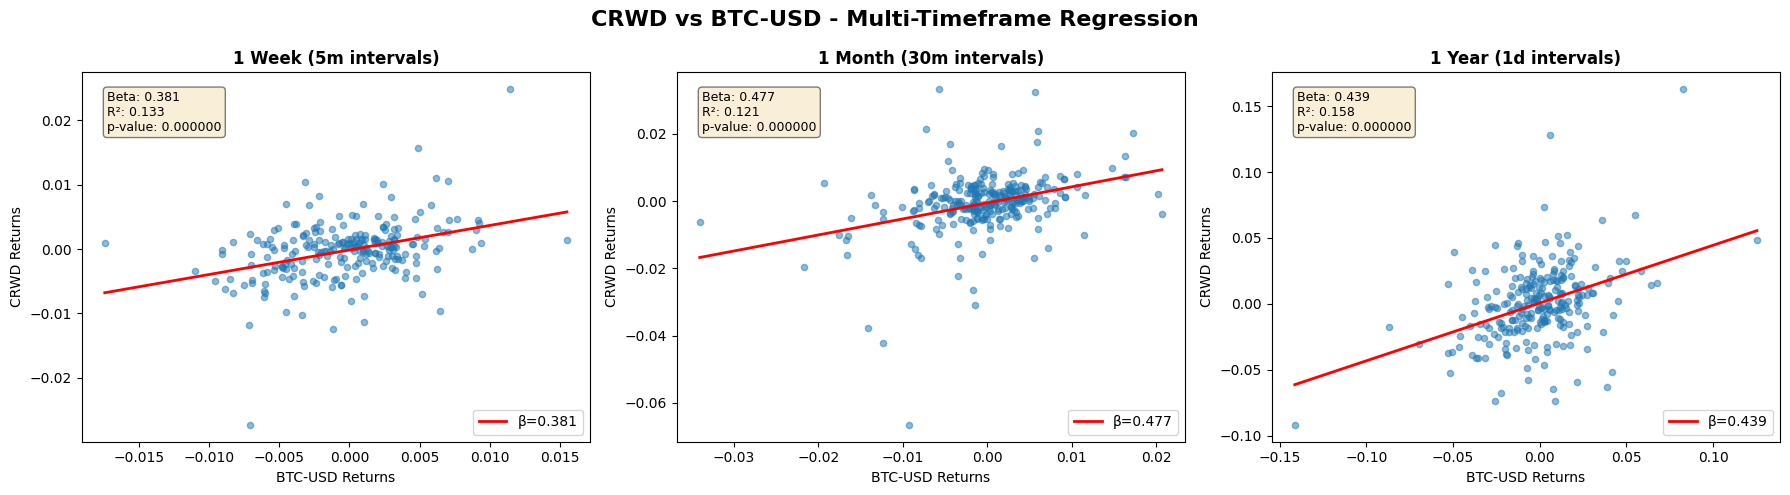


Analyzing: PANW vs BTC-USD


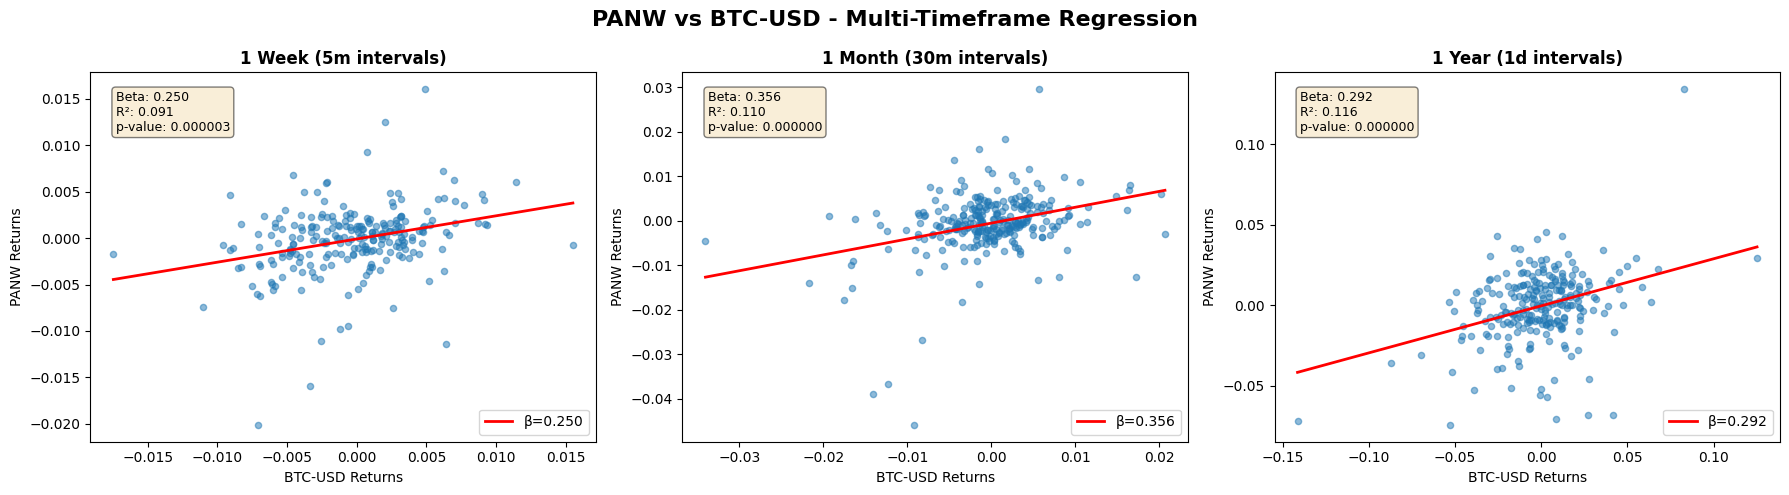


Analyzing: SNPS vs BTC-USD


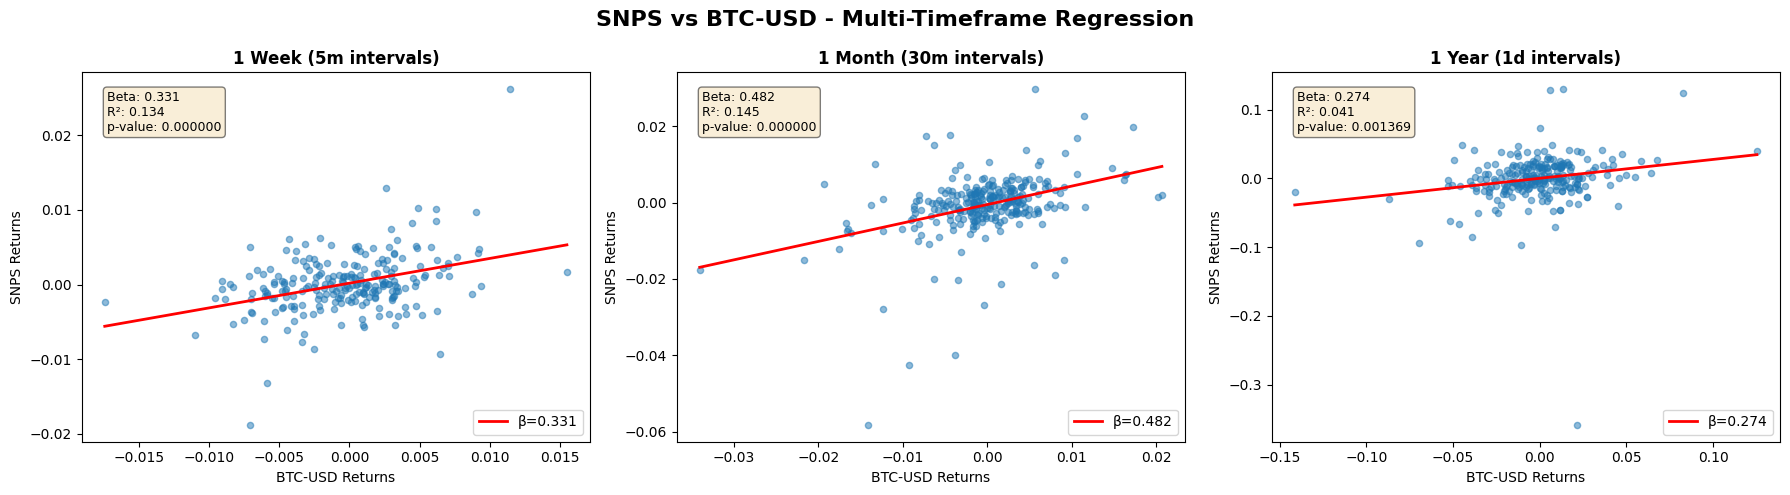


Analyzing: ADBE vs BTC-USD


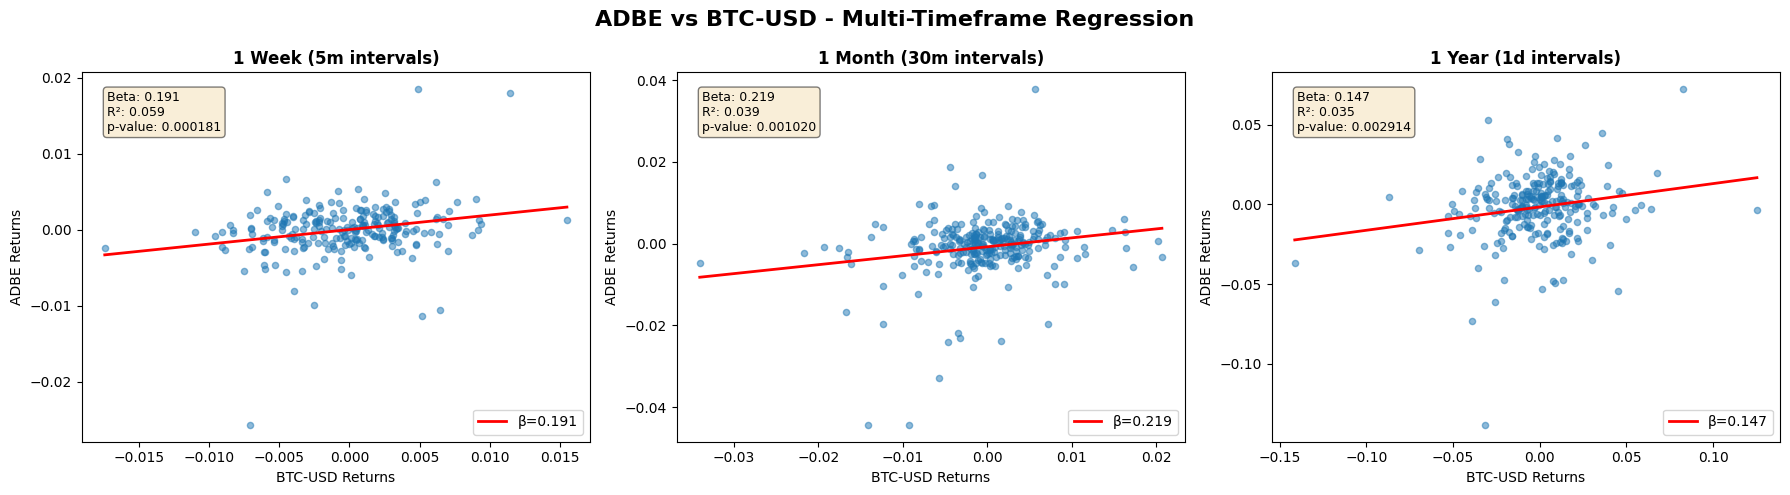


Analyzing: INTU vs BTC-USD


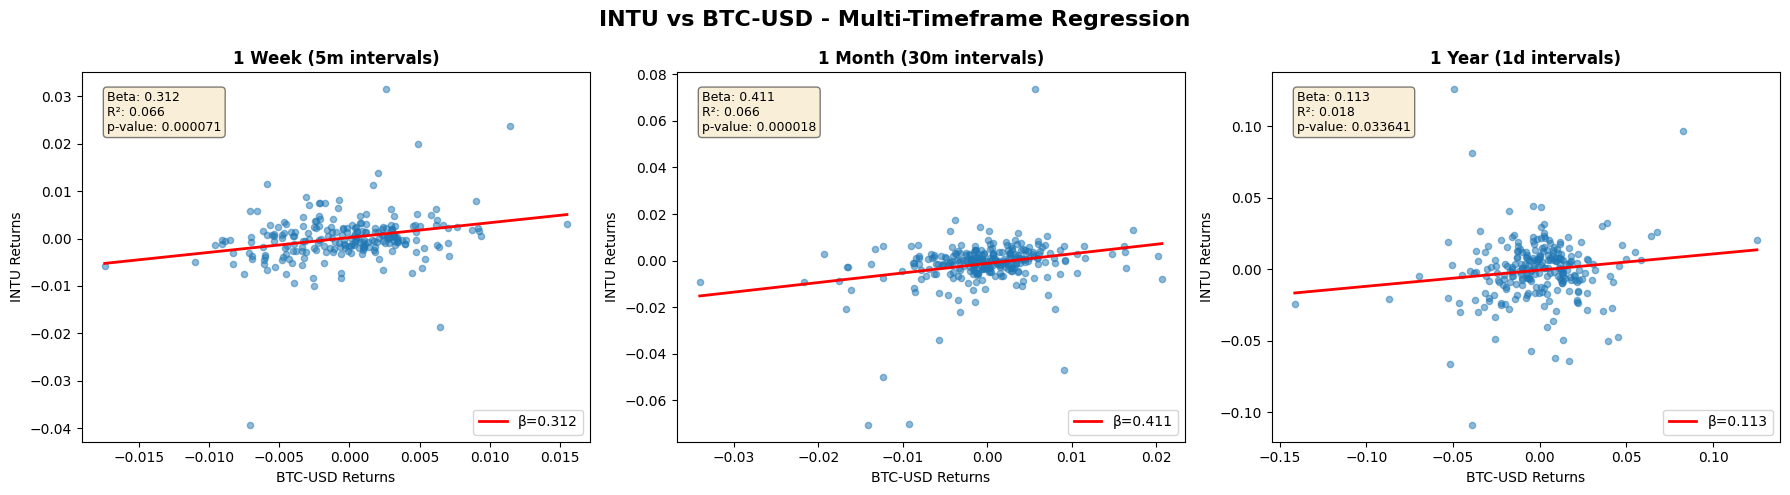


Analyzing: NOW vs BTC-USD


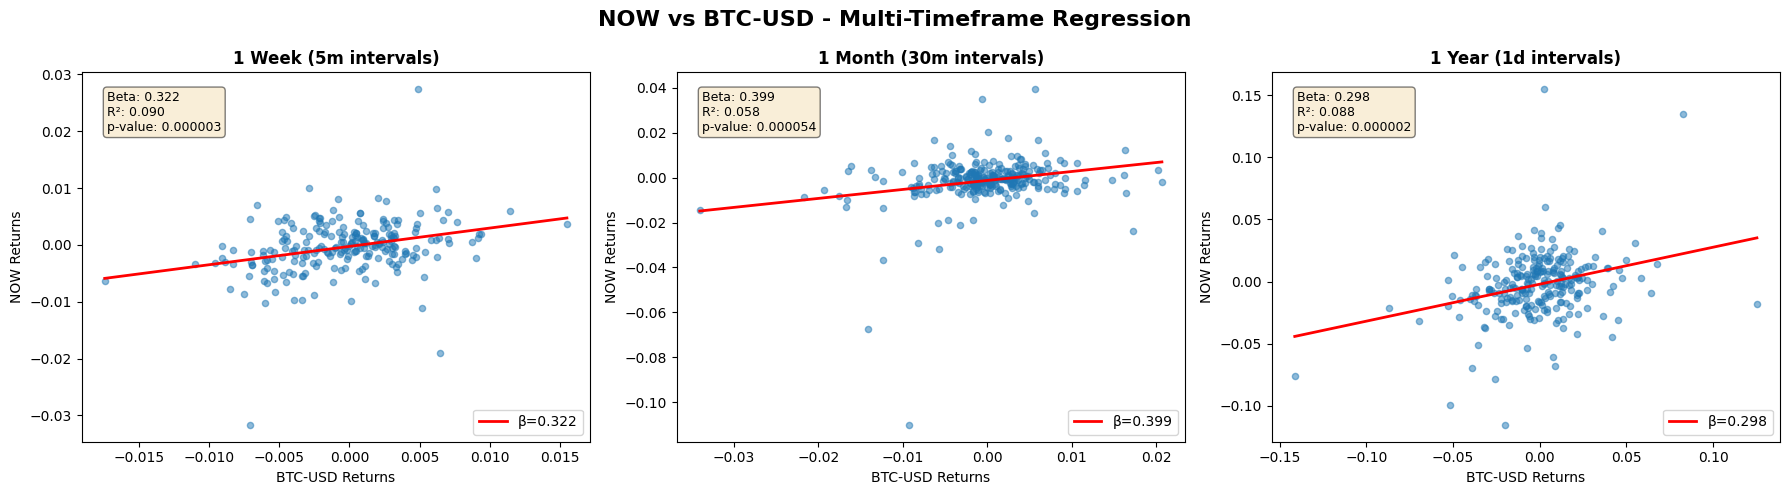


Analyzing: XSW vs BTC-USD


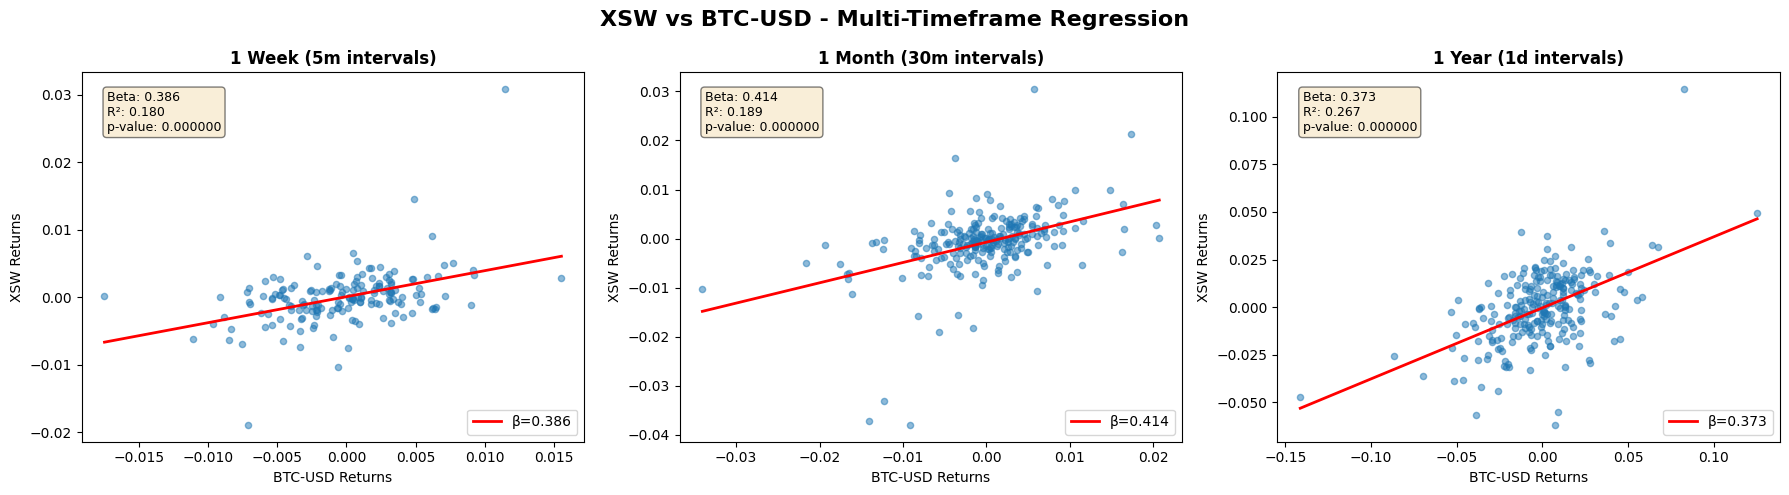


Analyzing: IGV vs BTC-USD


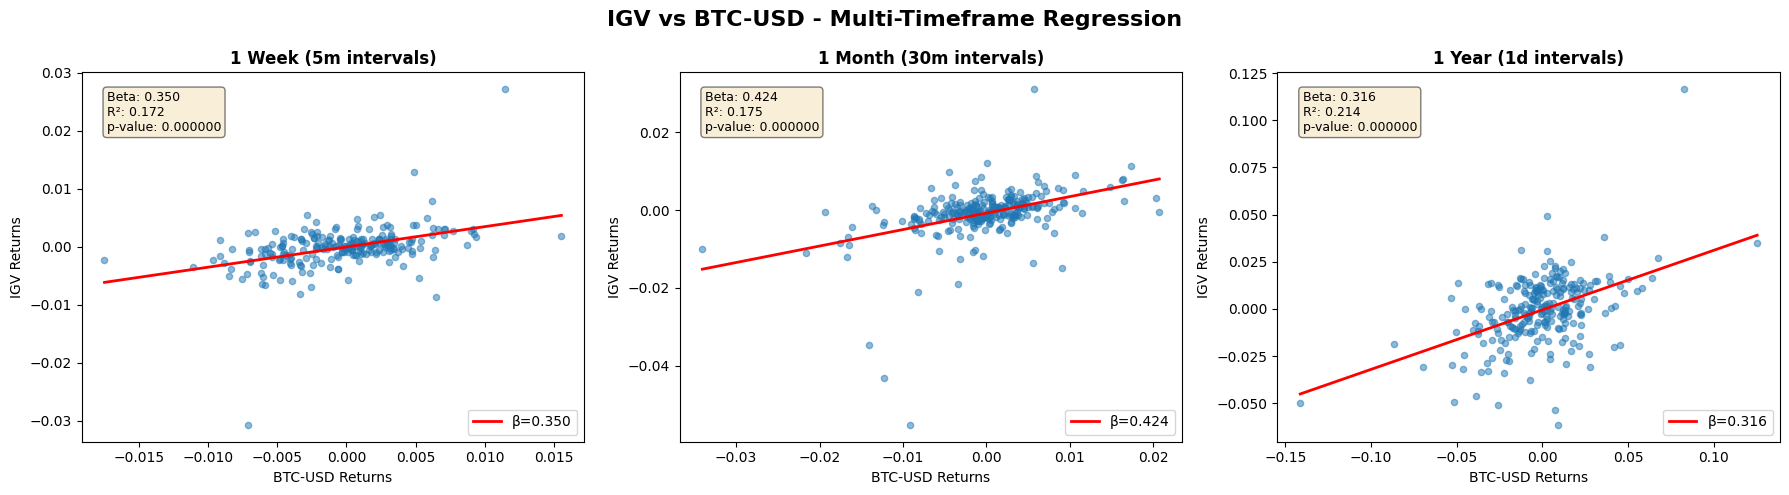


 Analysis Complete!


In [15]:
if __name__ == "__main__":

    
    main_ticker = 'BTC-USD'
    comparison_tickers = ['ORCL', 'PLTR', 'SNOW', 'CRM', 'WDAY', 'DDOG', 'NET', 'CRWD', 'PANW', 'SNPS', 'ADBE', 'INTU', 'NOW', 'XSW', 'IGV']

    
    tool = RegressionAnalysisTool(main_ticker, comparison_tickers)
    tool.run_analysis()